In [ ]:
import dask.dataframe as dd
import kagglehub
import shutil
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## getting data from kaggle

In [ ]:
path = kagglehub.dataset_download("mkechinov/ecommerce-behavior-data-from-multi-category-store")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ecommerce-behavior-data-from-multi-category-store


In [ ]:
%ls {path}

2019-Nov.csv  2019-Oct.csv


In [ ]:
root = os.getcwd()
raw_file_path = f"{root}/data/raw/"
os.makedirs(raw_file_path , exist_ok=True)

In [ ]:
# copy data to our working dir

for file in os.listdir(path):
  shutil.copy(f"{path}/{file}" , raw_file_path)

# remove main path dir
# shutil.rmtree(path)  #uncomment if using locally

## convert csv to parquet using dask for faster approch

In [ ]:
parquet_file_path = f"{root}/data/parquet/"
os.makedirs(parquet_file_path , exist_ok=True)

In [ ]:
def merge_and_convert():
  df = dd.DataFrame(pd.DataFrame())

  for i, file in enumerate(os.listdir(raw_file_path)):
    data = dd.read_csv(f"{raw_file_path}/{file}")
    df = dd.concat([df, data])

  df.to_parquet(f"{parquet_file_path}MERGED.parquet")

  return f"{parquet_file_path}MERGED.parquet"

In [ ]:
parquet_file = merge_and_convert()

In [ ]:
# Uncomment the line below to create a zip file of the '/content/data/parquet' folder for local download
# shutil.make_archive('/content/data_parquet_zip', 'zip', '/content/data/parquet')

In [ ]:
columns = ["event_time", "event_type", "category_code", "brand", "price", "user_id"]

df = dd.read_parquet(parquet_file , columns= columns)

In [ ]:
df.head()

,event_time,event_type,category_code,brand,price,user_id
0,2019-10-01 00:00:00 UTC,view,<NA>,shiseido,35.79,541312140
1,2019-10-01 00:00:00 UTC,view,appliances.environment.water_heater,aqua,33.20,554748717
2,2019-10-01 00:00:01 UTC,view,furniture.living_room.sofa,<NA>,543.10,519107250
3,2019-10-01 00:00:01 UTC,view,computers.notebook,lenovo,251.74,550050854
4,2019-10-01 00:00:04 UTC,view,electronics.smartphone,apple,1081.98,535871217


In [ ]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 6 entries, event_time to user_id
dtypes: float64(1), int64(1), string(4)

In [ ]:
df["event_time"] = dd.to_datetime(df["event_time"], utc=True)

## Conversion Funnel Analysis

In [ ]:
# Filter once to avoid repeated filtering
views_df = df[df["event_type"] == "view"]
carts_df = df[df["event_type"] == "cart"]
purchases_df = df[df["event_type"] == "purchase"]

# Compute unique user counts
total_views = views_df["user_id"].nunique()
total_carts = carts_df["user_id"].nunique()
total_purchases = purchases_df["user_id"].nunique()

# Compute all at once (efficient and readable)
views, carts, purchases = dd.compute(total_views, total_carts, total_purchases)

# Calculate conversion rates
cart_rate = carts / views
purchase_rate = purchases / carts

print("Cart Conversion Rate:", cart_rate)
print("Purchase Conversion Rate:", purchase_rate)

Cart Conversion Rate: 0.19828961981351842
Purchase Conversion Rate: 0.6616527515977585


### 💡 Funnel Conversion Insights

- **Cart Conversion Rate:** 19.8%
  - Only 1 in 5 users who viewed products added items to their cart.
- **Purchase Conversion Rate:** 66.2%
  - Two-thirds of users who carted proceeded to purchase.
- Focus on improving carting behavior — the biggest drop-off is at the view → cart stage.

## User Behavior Patterns

In [ ]:
result = df.groupby(["user_id" , "event_type"]).size().reset_index()

# Rename columns (there will now be 3)
result.columns = ["user_id", "event_type", "count"]

# Convert to pandas (if using dask_cudf)
result_pd = result.compute()

In [ ]:
pivot_result = result_pd.pivot_table(index="user_id", columns="event_type", values="count", aggfunc="sum", fill_value=0)

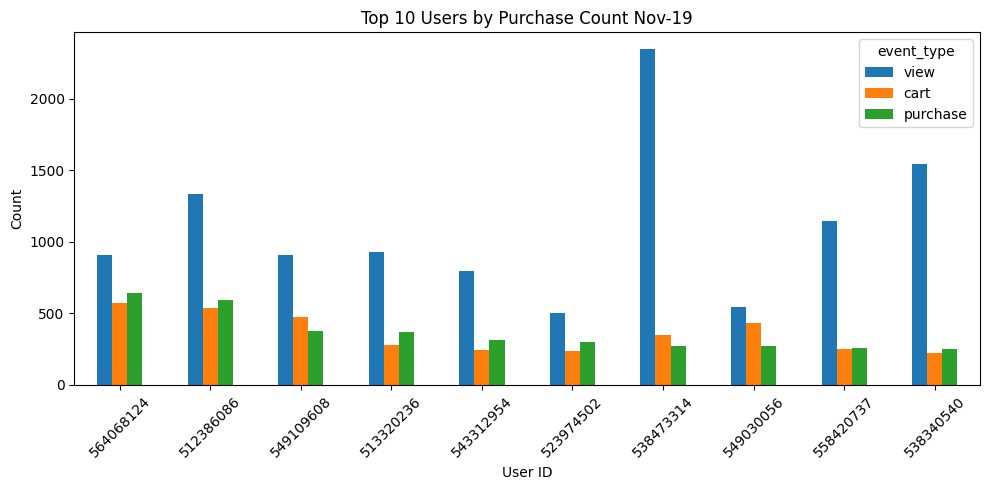

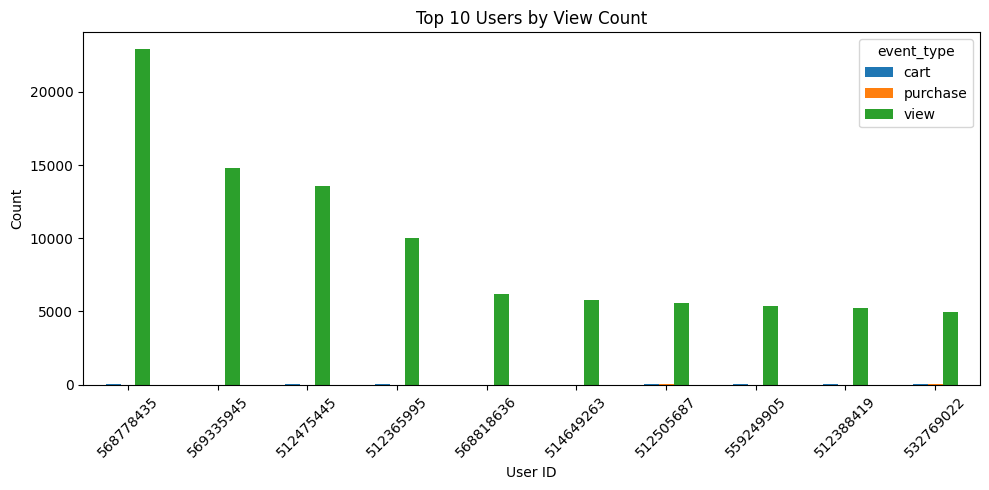

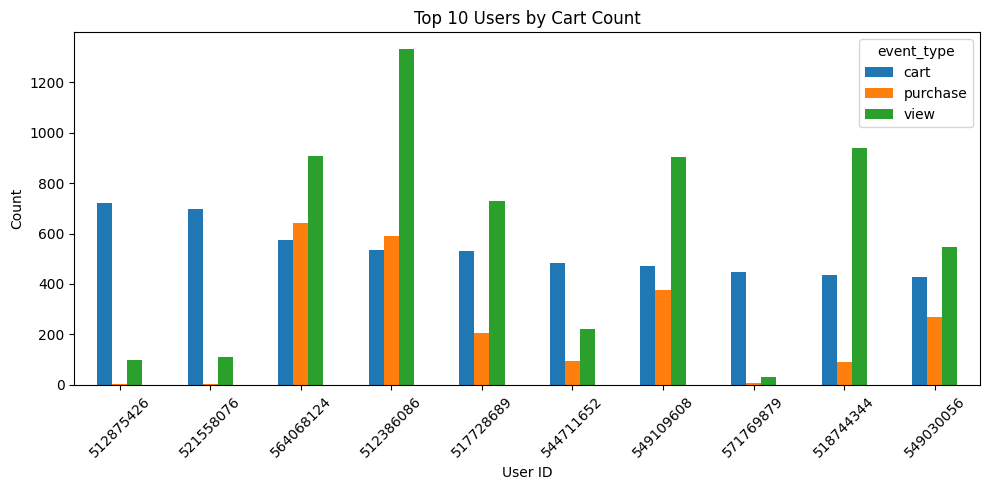

In [ ]:
# --- Top 10 by Purchase ---
pivot_result.sort_values(by="purchase", ascending=False).head(10)[["view", "cart", "purchase"]].plot(
    kind="bar",
    figsize=(10, 5),
    title="Top 10 Users by Purchase Count Nov-19",
    ylabel="Count",
    xlabel="User ID"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Top 10 by View ---
pivot_result.sort_values(by="view", ascending=False).head(10).plot(
    kind="bar",
    figsize=(10, 5),
    title="Top 10 Users by View Count",
    ylabel="Count",
    xlabel="User ID"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Top 10 by Cart ---
pivot_result.sort_values(by="cart", ascending=False).head(10).plot(
    kind="bar",
    figsize=(10, 5),
    title="Top 10 Users by Cart Count",
    ylabel="Count",
    xlabel="User ID"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- High views ≠ High purchases
→ It's not necessary that users who view products frequently end up purchasing them. High engagement doesn’t always lead to conversion.

- Cart activity aligns more with purchases
 → Users who make more purchases tend to add more items to their cart, indicating stronger buying intent.

- Cart ≠ Purchase always
 → Adding to cart does not guarantee a purchase — this is often where users drop off in the funnel.

- Conversion Rate ≈ 53%
 → The conversion rate from cart to purchase being only 53% shows that nearly half the users abandon their cart. This suggests room for improvement

In [ ]:
df["event_hour"] = df["event_time"].dt.floor("H")

grouped = df.groupby(["user_id", "event_hour", "event_type"]).size()
grouped_df = grouped.rename("count").reset_index()

result = grouped_df.compute()

In [ ]:
result.head()

,user_id,event_hour,event_type,count
0,170313967,2019-11-11 16:00:00+00:00,view,1
1,200776308,2019-11-11 21:00:00+00:00,view,1
2,217788814,2019-11-12 05:00:00+00:00,view,1
3,239198635,2019-11-12 01:00:00+00:00,view,1
4,262389408,2019-11-12 07:00:00+00:00,view,1


## Product/Brand Performance

In [ ]:
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute event counts from Dask DataFrame
event_counts = df["event_type"].value_counts().compute()

# Convert to DataFrame
event_counts_df = event_counts.reset_index()
event_counts_df.columns = ['event_type', 'count']

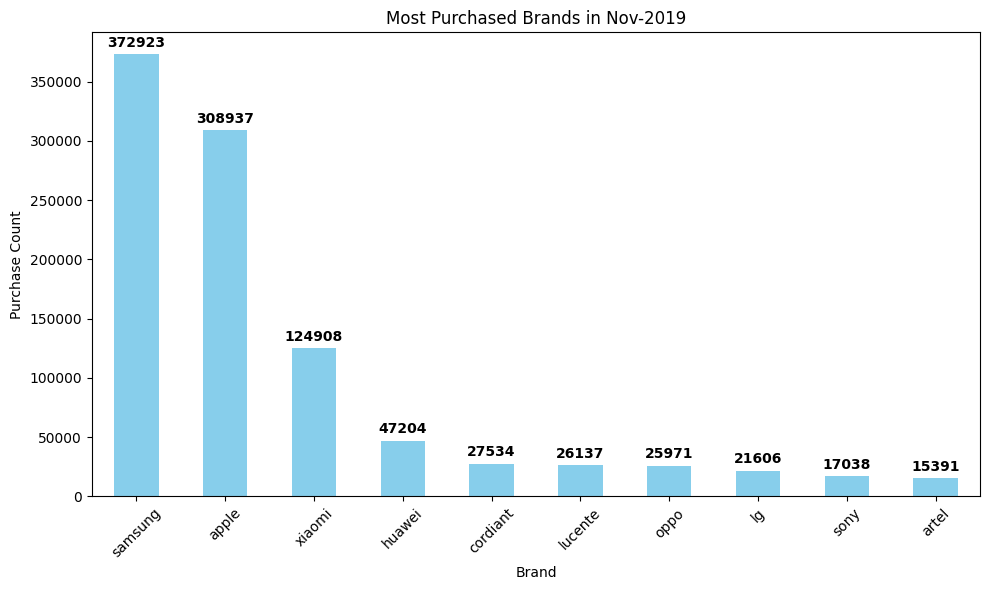

/tmp/ipython-input-3780955961.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{y/1e6:.1f}M' for y in ax2.get_yticks()])


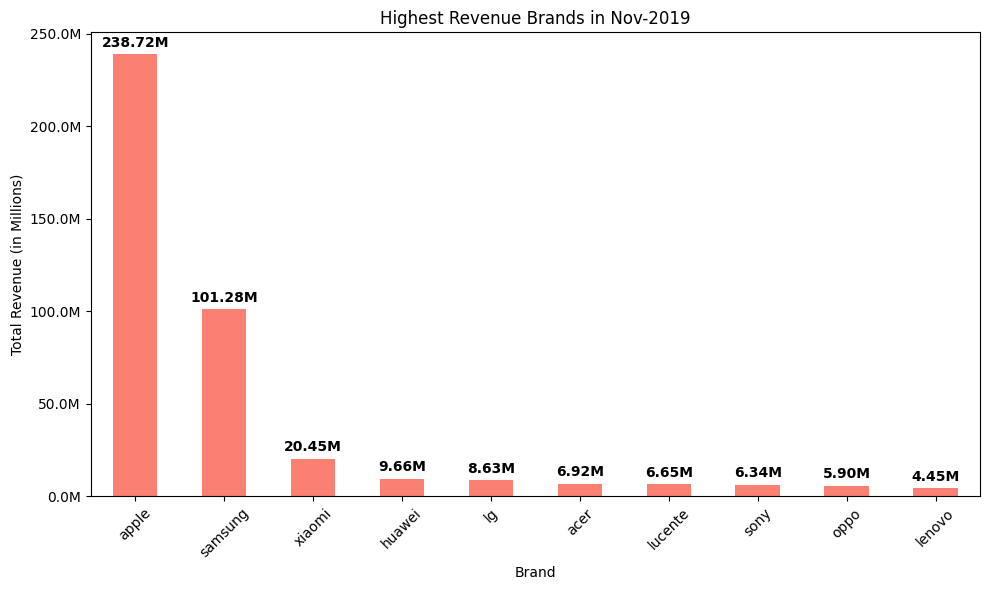

In [ ]:
import matplotlib.pyplot as plt

# Compute if using Dask
purchase = df[df["event_type"] == "purchase"].compute()

# --- Plot 1: Most Purchased Brands ---
most_purchased = purchase["brand"].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax1 = most_purchased.plot(kind="bar", title="Most Purchased Brands", color="skyblue")
plt.ylabel("Purchase Count")
plt.xlabel("Brand")
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(most_purchased.values):
    ax1.text(i, v + max(most_purchased.values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# --- Plot 2: Highest Revenue Brands ---
highest_revenue = purchase.groupby("brand")["price"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax2 = highest_revenue.plot(kind="bar", title="Highest Revenue Brands", color="salmon")
plt.ylabel("Total Revenue (in Millions)")
plt.xlabel("Brand")
plt.xticks(rotation=45)

# Add value labels in Millions (M)
for i, v in enumerate(highest_revenue.values):
    ax2.text(i, v + max(highest_revenue.values)*0.01, f'{v/1e6:.2f}M', ha='center', va='bottom', fontweight='bold')

# Format Y-axis ticks to Millions
ax2.set_yticklabels([f'{y/1e6:.1f}M' for y in ax2.get_yticks()])

plt.tight_layout()
plt.show()
